In [50]:
import json
import os
import re

from json import JSONDecodeError

import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
import matplotlib.pyplot as plt

def wrap_plot(x_data, y_data, plot_type="line", color="#007acc", alpha=1, xticks=None, grid=None, legenddata=None, legend=False, xlabel="", ylabel="", vertical_line_date=None):
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('#0c1c23')

    if plot_type == "line":
        ax.plot(x_data, y_data, color=color, alpha=alpha)
    elif plot_type == "bar":
        ax.bar(x_data, y_data, color=color, alpha=alpha)
    elif plot_type == "scatter":
        ax.scatter(x_data, y_data, color=color, alpha=alpha)

    ax.set_facecolor('#122229')
    ax.spines['left'].set_color('#FFFFFF')
    ax.spines['left'].set_linewidth(0.5)

    ax.spines['bottom'].set_color("#3C494F")
    ax.spines['bottom'].set_linewidth(0.3)
    ax.spines['top'].set_color("#3C494F")
    ax.spines['top'].set_linewidth(0.3)
    ax.spines['right'].set_color("#3C494F")
    ax.spines['right'].set_linewidth(0.3)

    ax.tick_params(axis='both', colors='#FFFFFF')

    if xticks is not None:
        ax.set_xticklabels(xticks)

    if grid is not None:
        plt.grid(color="#3C494F", linestyle=grid, linewidth=0.3)

    plt.xticks(rotation=45, ha='right', color="white")
    plt.yticks(color="white")

    if vertical_line_date is not None:
        plt.axvline(x=vertical_line_date, label='Christmas', color="white", linestyle='--', alpha=0.75)

    plt.xlabel(xlabel, color="white", fontweight="bold", fontsize=10)
    plt.ylabel(ylabel, color="white", fontweight="bold", fontsize=10)

    if legend:
        plt.legend(legenddata)

    plt.tight_layout()
    plt.show()

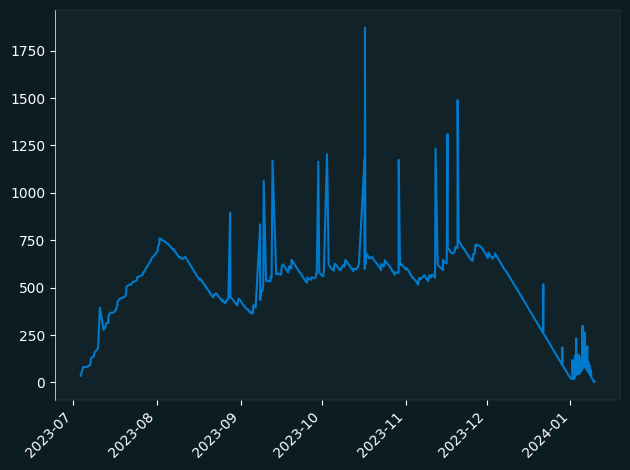

In [91]:
files = os.listdir("/home/s371513/ernie/data/earthquakes/")

ms = []

for file in files:
    with open(os.path.join("/home/s371513/ernie/data/earthquakes/", file)) as f:
        try:
            j = json.loads(
                f.read()
                .replace("経度", "long")
                .replace("緯度", "lat")
                .replace("震源地", "epicenter_loc")
                .replace("震源深さ", "epicenter_depth")
                .replace("発生日時", "timestamp")
                .replace("マグニチュード", "magnitude")
                .replace("最大震度", "maximum_intensity")
                .replace("：", ": ")
                .replace("[EEW]", "")
                .replace("km", "")
            )

            for i in range(len(j)):
                for m in re.finditer('2023/', j[i]["text"]):
                    jl = list(j[i]["text"])
                    jl[m.start() + 10] = "-"
                    j[i]["text"] = "".join(jl)
                    
                for m in re.finditer('2024/', j[i]["text"]):
                    jl = list(j[i]["text"])
                    jl[m.start() + 10] = "-"
                    j[i]["text"] = "".join(jl)

                m = {key: value for key, value in zip(*[iter(j[i]["text"].replace(": ", " ").split())] * 2)}

                ms.append(m)
        except JSONDecodeError as _:
            pass

df = pd.DataFrame(ms, columns=["ID", "SEQ", "epicenter_loc", "lat", "long", "epicenter_depth", "timestamp", "magnitude", "maximum_intensity"])

df["long"] = df["long"].astype(float)
df["lat"] = df["lat"].astype(float)
df["magnitude"] = df["magnitude"].astype(float)
df["epicenter_depth"] = df["epicenter_depth"].astype(float)

df['geometry'] = gpd.points_from_xy(df['long'], df['lat'])
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf["timestamp"] = pd.to_datetime(gdf["timestamp"])
gdf["timestamp"] = gdf["timestamp"].dt.round('1h')

timeline = gdf.groupby(by="timestamp").size().reset_index(name="count")
min_time = timeline["timestamp"].min()
max_time = timeline["timestamp"].max()
time_range = pd.date_range(start=min_time, end=max_time, freq='1h')
timeline_filled = pd.DataFrame(data={'count': 0, "timestamp": time_range})

#result_df = pd.merge(timeline_filled, timeline, on='timestamp', how='left')
#result_df['count_y'].fillna(0, inplace=True)
#result_df.rename(columns={'count_y': 'count'}, inplace=True)
#result_df.drop(columns=['count_x'], inplace=True)


wrap_plot(timeline["timestamp"], timeline["count"])
